<a href="https://colab.research.google.com/github/marcinwolter/MachineLearning-KISD-2025/blob/main/HIGGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstrator for P. Baldi, P. Sadowski and D. Whiteson paper

**Marcin Wolter**

March 2025

The aim of the iPython notebook is to repeat (in some extend) the analysis from the paper:
*Pierre Baldi, Peter Sadowski, and Daniel Whiteson. "Searching for exotic particles in high-energy physics with deep learning." Nature communications 5.1 (2014): 4308.*

https://arxiv.org/pdf/1402.4735

In which simulated exotic Higgs data are analysed once using seven high-level variables and than using 21 low-level. Using benchmark datasets, authors show
that deep learning methods need no manually constructed inputs and yet improve the classification
metric by as much as 8% over the best current approaches. This demonstrates that deep learning
approaches can improve the power of collider searches for exotic particles.
 
Here the analisis is repeated using using  high level vs. 21 low level variables and Deep Neural network with six fully connected layers of 256 nodes each vs. a shallow network with one hidden layers of 256 nodes. Both networks are using Keras and Tensorflow, since https://scikit-learn.org/ not using GPU appeared to be very slow with 11 000 000 input events.
 
Example networks (not optimized) show that Deep NN works better with 21 low level variables than with 7 high level. Shallow and deep NN are getting similar results with high-level variables. Shallow NN is slightly better with high-level variables than with the low-level ones.


## Setup

In [1]:
import numpy as np
import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

import urllib.request # Added for downloading the file
from numpy import loadtxt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt


2025-03-31 09:52:01.118538: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-31 09:52:01.145058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743407521.171009     334 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743407521.178821     334 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-31 09:52:01.207315: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Prepare the data

Data is loaded from a repository: https://archive.ics.uci.edu/dataset/280/higgs

In [2]:
# Model / data parameters

# Download the dataset
url = 'https://archive.ics.uci.edu/static/public/280/higgs.zip'
urllib.request.urlretrieve(url, 'higgs.zip') # Downloads and saves as 'higgs.zip'
!unzip higgs.zip

# load the dataset and limit the number of rows
#dataset = loadtxt('HIGGS.csv.gz', delimiter=',', max_rows=1000000)
dataset = loadtxt('HIGGS.csv.gz', delimiter=',', max_rows=100000000)
#print("Dataset")
#print(dataset[0:3])


y = dataset[:,0]
#x_all = StandardScaler().fit_transform(dataset[:,1:])
x_all = dataset[:,1:]
x_low = x_all[:,0:21]
x_high = x_all[:,21:]



x_all_train, x_all_test, y_all_train, y_all_test = \
    train_test_split(x_all, y, test_size=.3, random_state=42)

x_high_train, x_high_test, y_high_train, y_high_test = \
    train_test_split(x_high, y, test_size=.3, random_state=42)

x_low_train, x_low_test, y_low_train, y_low_test = \
    train_test_split(x_low, y, test_size=.3, random_state=42)


print(y_high_train[0:30])
print(x_high_train[0:6])
#print(x_low[0:3])
print(x_all[0:3])

print(x_all.shape, x_low.shape, x_high.shape)

[0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1.
 1. 0. 1. 1. 0. 1.]
[[1.55077064 1.42924178 0.96978325 3.28541827 2.35854101 2.17012477
  1.76589775]
 [0.75602061 0.87680733 1.18323576 0.62514138 0.2845054  0.5460729
  0.62248605]
 [0.96856111 0.78884393 1.61452448 1.38508141 0.90039289 0.90939772
  0.85605228]
 [0.41823804 0.8599838  0.98427737 0.88090688 1.91217256 0.9732306
  0.75903004]
 [1.44288635 1.03603864 0.98777902 0.92367792 0.93193328 0.8609156
  0.76906252]
 [0.93364036 0.96409178 0.97917783 0.94170028 1.01798975 0.79026538
  0.7344445 ]]
[[ 8.69293213e-01 -6.35081828e-01  2.25690261e-01  3.27470064e-01
  -6.89993203e-01  7.54202247e-01 -2.48573139e-01 -1.09206390e+00
   0.00000000e+00  1.37499213e+00 -6.53674185e-01  9.30349112e-01
   1.10743606e+00  1.13890433e+00 -1.57819831e+00 -1.04698539e+00
   0.00000000e+00  6.57929540e-01 -1.04545699e-02 -4.57671694e-02
   3.10196137e+00  1.35376000e+00  9.79563117e-01  9.78076160e-01
   9.20004845e-01  7.

## Build the model high level variables

In [3]:
input_shape_high = (7,)

model_high = keras.Sequential(
    [
        keras.Input(shape=input_shape_high),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.02),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.02),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.02),        
        layers.Dense(1, activation="sigmoid"),
    ]
)

model_high.summary()

I0000 00:00:1743407760.661163     334 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:07.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331,265 (1.26 MB)

 Trainable params: 331,265 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [4]:
batch_size = 128
epochs = 50

model_high.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',  # Maximize validation accuracy
    verbose=1,
    restore_best_weights=True
)

history_high = model_high.fit(x_high_train, y_high_train, batch_size=batch_size, epochs=epochs, 
                              validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50


I0000 00:00:1743407768.533693     433 service.cc:148] XLA service 0x7f82f800f580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743407768.533876     433 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-03-31 09:56:08.595259: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743407768.908703     433 cuda_dnn.cc:529] Loaded cuDNN version 90300


  101/54141 ━━━━━━━━━━━━━━━━━━━━ 1:38 2ms/step - accuracy: 0.5778 - loss: 0.6717

I0000 00:00:1743407771.675686     433 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54141/54141 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 0.6961 - loss: 0.5680 - val_accuracy: 0.7066 - val_loss: 0.5540
Epoch 2/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 91s 2ms/step - accuracy: 0.7092 - loss: 0.5511 - val_accuracy: 0.7090 - val_loss: 0.5514
Epoch 3/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 91s 2ms/step - accuracy: 0.7110 - loss: 0.5489 - val_accuracy: 0.7122 - val_loss: 0.5467
Epoch 4/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 91s 2ms/step - accuracy: 0.7123 - loss: 0.5471 - val_accuracy: 0.7128 - val_loss: 0.5474
Epoch 5/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 91s 2ms/step - accuracy: 0.7123 - loss: 0.5470 - val_accuracy: 0.7137 - val_loss: 0.5442
Epoch 6/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 91s 2ms/step - accuracy: 0.7131 - loss: 0.5464 - val_accuracy: 0.7143 - val_loss: 0.5436
Epoch 7/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 91s 2ms/step - accuracy: 0.7138 - loss: 0.5456 - val_accuracy: 0.7126 - val_loss: 0.5466
Epoch 8/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 91s 2ms/step - accuracy: 0.7129 - l

## Evaluate the trained model

In [5]:
score = model_high.evaluate(x_high_test, y_high_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.541693925857544
Test accuracy: 0.716155469417572


In [6]:
input_shape_low = (21,)

model_low = keras.Sequential(
    [
        keras.Input(shape=input_shape_low),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.02),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.02),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.02),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model_low.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 256)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,849 (1.28 MB)

 Trainable params: 334,849 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [7]:
batch_size = 128
epochs = 50

model_low.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',  # Maximize validation accuracy
    verbose=1,
    restore_best_weights=True
)

history_low=model_low.fit(x_low_train, y_low_train, batch_size=batch_size, epochs=epochs, 
                          validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 101s 2ms/step - accuracy: 0.6688 - loss: 0.6014 - val_accuracy: 0.7222 - val_loss: 0.5442
Epoch 2/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step - accuracy: 0.7263 - loss: 0.5389 - val_accuracy: 0.7377 - val_loss: 0.5245
Epoch 3/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 93s 2ms/step - accuracy: 0.7384 - loss: 0.5220 - val_accuracy: 0.7429 - val_loss: 0.5169
Epoch 4/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step - accuracy: 0.7448 - loss: 0.5133 - val_accuracy: 0.7500 - val_loss: 0.5050
Epoch 5/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step - accuracy: 0.7489 - loss: 0.5071 - val_accuracy: 0.7523 - val_loss: 0.5011
Epoch 6/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step - accuracy: 0.7512 - loss: 0.5038 - val_accuracy: 0.7538 - val_loss: 0.5022
Epoch 7/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step - accuracy: 0.7524 - loss: 0.5018 - val_accuracy: 0.7545 - val_loss: 0.4975
Epoch 8/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 95s 2ms/step - accuracy:

## Evaluate the trained model

In [8]:
score = model_low.evaluate(x_low_test, y_low_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.49336594343185425
Test accuracy: 0.7575712203979492


# Plot the accuracy and loss

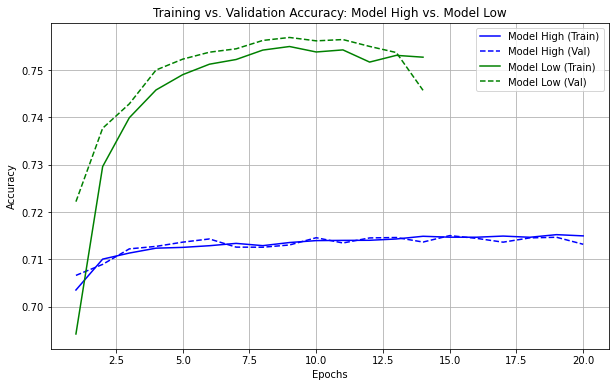

In [9]:
plt.figure(figsize=(10, 6))

# Model High
epochs_high = range(1, len(history_high.history['accuracy']) + 1)
plt.plot(epochs_high, history_high.history['accuracy'], label='Model High (Train)', color='blue')
plt.plot(epochs_high, history_high.history['val_accuracy'], label='Model High (Val)', color='blue', linestyle='--')

# Model Low
epochs_low = range(1, len(history_low.history['accuracy']) + 1)
plt.plot(epochs_low, history_low.history['accuracy'], label='Model Low (Train)', color='green')
plt.plot(epochs_low, history_low.history['val_accuracy'], label='Model Low (Val)', color='green', linestyle='--')

plt.title('Training vs. Validation Accuracy: Model High vs. Model Low')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

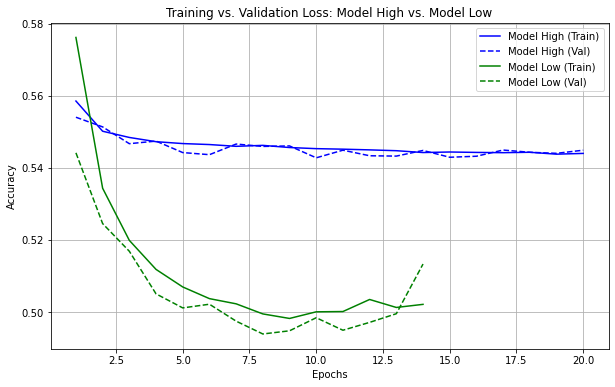

In [10]:
plt.figure(figsize=(10, 6))

# Model High
epochs_high = range(1, len(history_high.history['loss']) + 1)
plt.plot(epochs_high, history_high.history['loss'], label='Model High (Train)', color='blue')
plt.plot(epochs_high, history_high.history['val_loss'], label='Model High (Val)', color='blue', linestyle='--')

# Model Low
epochs_low = range(1, len(history_low.history['loss']) + 1)
plt.plot(epochs_low, history_low.history['loss'], label='Model Low (Train)', color='green')
plt.plot(epochs_low, history_low.history['val_loss'], label='Model Low (Val)', color='green', linestyle='--')

plt.title('Training vs. Validation Loss: Model High vs. Model Low')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot the ROC curves

In [11]:
# Generate predicted probabilities for both models
y_pred_high = model_high.predict(x_high_test)
y_pred_low = model_low.predict(x_low_test)

103125/103125 ━━━━━━━━━━━━━━━━━━━━ 134s 1ms/step


In [12]:

# Compute ROC curves and AUC for both models
fpr_high, tpr_high, _ = roc_curve(y_high_test, y_pred_high)
roc_auc_high = auc(fpr_high, tpr_high)

fpr_low, tpr_low, _ = roc_curve(y_low_test, y_pred_low)
roc_auc_low = auc(fpr_low, tpr_low)

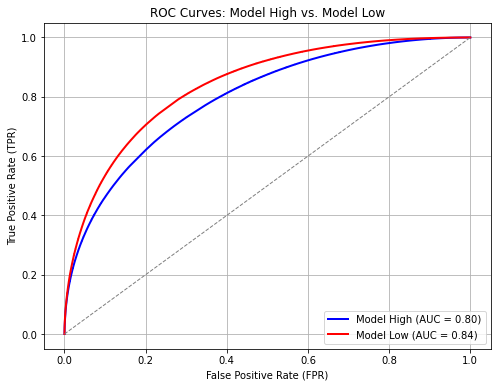

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_high, tpr_high, color='blue', lw=2,
         label=f'Model High (AUC = {roc_auc_high:.2f})')
plt.plot(fpr_low, tpr_low, color='red', lw=2,
         label=f'Model Low (AUC = {roc_auc_low:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves: Model High vs. Model Low')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Train the shallow neural network

## Build the model

In [28]:
input_shape_high = (7,)

model_high_shallow = keras.Sequential(
    [
        keras.Input(shape=input_shape_high),
        layers.Dense(256, activation="tanh"),
        layers.Dropout(0.02),        
        layers.Dense(1, activation="sigmoid"),
    ]
)

model_high_shallow.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,305 (9.00 KB)

 Trainable params: 2,305 (9.00 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [29]:
batch_size = 128
epochs = 50

model_high_shallow.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',  # Maximize validation accuracy
    verbose=1,
    restore_best_weights=True
)

history_high_shallow = model_high_shallow.fit(x_high_train, y_high_train, batch_size=batch_size, epochs=epochs, 
                              validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 79s 1ms/step - accuracy: 0.6368 - loss: 0.6401 - val_accuracy: 0.6716 - val_loss: 0.6096
Epoch 2/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 76s 1ms/step - accuracy: 0.6677 - loss: 0.6070 - val_accuracy: 0.6875 - val_loss: 0.5896
Epoch 3/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 75s 1ms/step - accuracy: 0.6823 - loss: 0.5916 - val_accuracy: 0.6929 - val_loss: 0.5808
Epoch 4/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 77s 1ms/step - accuracy: 0.6880 - loss: 0.5837 - val_accuracy: 0.6955 - val_loss: 0.5743
Epoch 5/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 75s 1ms/step - accuracy: 0.6916 - loss: 0.5783 - val_accuracy: 0.6972 - val_loss: 0.5705
Epoch 6/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 80s 1ms/step - accuracy: 0.6935 - loss: 0.5752 - val_accuracy: 0.6971 - val_loss: 0.5686
Epoch 7/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 76s 1ms/step - accuracy: 0.6956 - loss: 0.5721 - val_accuracy: 0.7001 - val_loss: 0.5661
Epoch 8/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 76s 1ms/step - accuracy: 

## Evaluate the trained model

In [30]:
score = model_high_shallow.evaluate(x_high_test, y_high_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5566539168357849
Test accuracy: 0.7064082026481628


In [31]:
input_shape_low = (21,)

model_low_shallow = keras.Sequential(
    [
        keras.Input(shape=input_shape_low),
        layers.Dense(256, activation="tanh"),
        layers.Dropout(0.02),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model_low_shallow.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 256)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,889 (23.00 KB)

 Trainable params: 5,889 (23.00 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [32]:
batch_size = 128
epochs = 50

model_low_shallow.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',  # Maximize validation accuracy
    verbose=1,
    restore_best_weights=True
)

history_low_shallow=model_low_shallow.fit(x_low_train, y_low_train, batch_size=batch_size, epochs=epochs, 
                          validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 77s 1ms/step - accuracy: 0.6136 - loss: 0.6497 - val_accuracy: 0.6607 - val_loss: 0.6130
Epoch 2/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 77s 1ms/step - accuracy: 0.6583 - loss: 0.6153 - val_accuracy: 0.6686 - val_loss: 0.6056
Epoch 3/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 80s 1ms/step - accuracy: 0.6671 - loss: 0.6070 - val_accuracy: 0.6750 - val_loss: 0.5991
Epoch 4/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 78s 1ms/step - accuracy: 0.6714 - loss: 0.6025 - val_accuracy: 0.6784 - val_loss: 0.5962
Epoch 5/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 74s 1ms/step - accuracy: 0.6740 - loss: 0.6000 - val_accuracy: 0.6814 - val_loss: 0.5929
Epoch 6/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 72s 1ms/step - accuracy: 0.6763 - loss: 0.5979 - val_accuracy: 0.6836 - val_loss: 0.5906
Epoch 7/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 73s 1ms/step - accuracy: 0.6772 - loss: 0.5969 - val_accuracy: 0.6841 - val_loss: 0.5906
Epoch 8/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 74s 1ms/step - accuracy: 

## Evaluate the trained model

In [33]:
score = model_low_shallow.evaluate(x_low_test, y_low_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.584158182144165
Test accuracy: 0.6898884773254395


# Plot the accuracy and loss

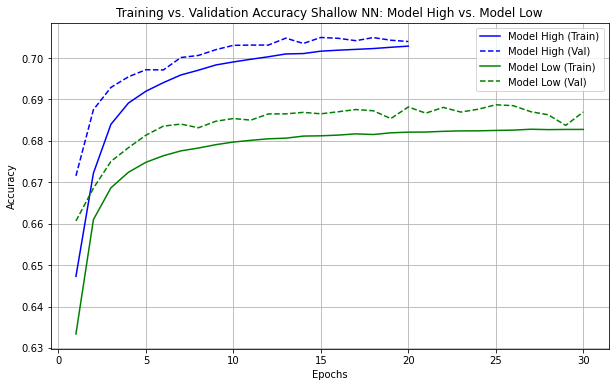

In [34]:
plt.figure(figsize=(10, 6))

# Model High
epochs_high = range(1, len(history_high_shallow.history['accuracy']) + 1)
plt.plot(epochs_high, history_high_shallow.history['accuracy'], label='Model High (Train)', color='blue')
plt.plot(epochs_high, history_high_shallow.history['val_accuracy'], label='Model High (Val)', color='blue', linestyle='--')

# Model Low
epochs_low = range(1, len(history_low_shallow.history['accuracy']) + 1)
plt.plot(epochs_low, history_low_shallow.history['accuracy'], label='Model Low (Train)', color='green')
plt.plot(epochs_low, history_low_shallow.history['val_accuracy'], label='Model Low (Val)', color='green', linestyle='--')

plt.title('Training vs. Validation Accuracy Shallow NN: Model High vs. Model Low')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

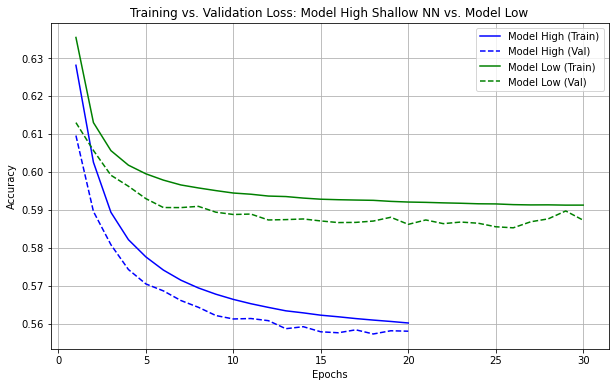

In [35]:
plt.figure(figsize=(10, 6))

# Model High
epochs_high = range(1, len(history_high_shallow.history['loss']) + 1)
plt.plot(epochs_high, history_high_shallow.history['loss'], label='Model High (Train)', color='blue')
plt.plot(epochs_high, history_high_shallow.history['val_loss'], label='Model High (Val)', color='blue', linestyle='--')

# Model Low
epochs_low = range(1, len(history_low_shallow.history['loss']) + 1)
plt.plot(epochs_low, history_low_shallow.history['loss'], label='Model Low (Train)', color='green')
plt.plot(epochs_low, history_low_shallow.history['val_loss'], label='Model Low (Val)', color='green', linestyle='--')

plt.title('Training vs. Validation Loss: Model High Shallow NN vs. Model Low')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot the ROC curves

In [36]:
# Generate predicted probabilities for both models
y_pred_high = model_high_shallow.predict(x_high_test)
y_pred_low = model_low_shallow.predict(x_low_test)

103125/103125 ━━━━━━━━━━━━━━━━━━━━ 112s 1ms/step
 21833/103125 ━━━━━━━━━━━━━━━━━━━━ 1:27 1ms/step

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [37]:

# Compute ROC curves and AUC for both models
fpr_high, tpr_high, _ = roc_curve(y_high_test, y_pred_high)
roc_auc_high = auc(fpr_high, tpr_high)

fpr_low, tpr_low, _ = roc_curve(y_low_test, y_pred_low)
roc_auc_low = auc(fpr_low, tpr_low)

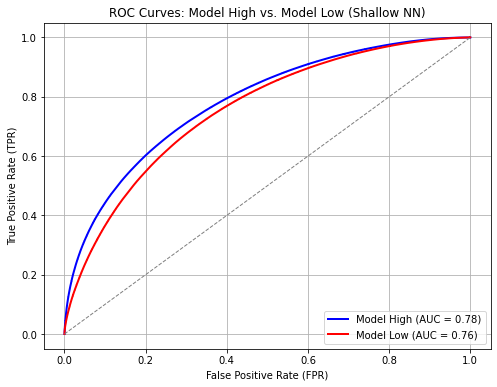

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_high, tpr_high, color='blue', lw=2,
         label=f'Model High (AUC = {roc_auc_high:.2f})')
plt.plot(fpr_low, tpr_low, color='red', lw=2,
         label=f'Model Low (AUC = {roc_auc_low:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves: Model High vs. Model Low (Shallow NN)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()